In [1]:
import fmri_funcs
import numpy as np
import pandas as pd
import subprocess
import os
import shutil
import itertools
import matplotlib.pyplot as plt
import warnings

In [6]:
warnings.filterwarnings('ignore')

study ='spaceloc'
subj_list=["spaceloc1001","spaceloc1002","spaceloc1003","spaceloc1004","spaceloc1005","spaceloc1006"] #subs to analyze
subj_list=["spaceloc1001"]

loc_suf = "_spaceloc" #runs to pull ROIs from
rois=["V3ab", "PPC", "APC", "V4", "LO", "PFS"] #Rois
roi_cope=[1, 1, 1, 2, 2, 2] #copes for localizer runs; corresponding numerically to each roi

exp = ['spaceloc','depthloc','distloc','toolloc'] #experimental tasks
exp_suf = [""]

exp_cope=[[4,5], [4,5], [4,5], [6,7]] #copes to test in each ROI; each minus fix
#exp_cope=[[1,2], [1,2], [1,2], [1,2]] #copes to test in each roi; each minus their contrast (e.g., space -feature)


bin_size=100
peak_vox=200
max_vox =2000

cond = [['space','feature'], ['3D',"2D"], ['distance', 'luminance'], ['tool','non_tool']]
#cond = [['space_loc','feature_loc'], ['3D_loc',"2D_loc"], ['distance_loc', 'luminance_loc'], ['tool_loc','non_tool_loc']]


bool_extract_data = True
bool_calc_act = True
bool_calc_mvpa = False


study_dir = f"/lab_data/behrmannlab/vlad/{study}"

In [7]:
def plot_vsf(df, roi,cond, y_ax, save):
    df = df[cond]
    df.columns = cond
    ax = df.plot.line()
    ax.set_xlabel("Number of Voxels")
    ax.set_ylabel(y_ax)
    plt.title(roi)
    plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
    plt.tight_layout()
    
    if save == True:
        plt.savefig(f'{sub_dir}/results/figures/{roi}_VSF.png',bbox_inches='tight')
        plt.close()

In [8]:
def plot_bar(df, roi,cond,save):
    df = df[cond]
    ax = df.plot.bar()
    ax.set_ylabel(f"Mean Beta {peak_vox} voxels")
    plt.title(roi)
    plt.tight_layout()
    
    if save == True:
        plt.savefig(f'{sub_dir}/results/figures/{roi}_mean.png',bbox_inches='tight')
        plt.close()
    

In [9]:
def plot_summary(df, roi, cond, save):
    df = df[cond]
    df_mean = df.mean()
    
    df_se =  df.sem() 
    
    
    plt.bar(cond, df_mean,  yerr=df_se)
    plt.ylabel(f"Mean Beta {peak_vox} voxels")
    plt.title(roi)
    
    if save == True:
        plt.savefig(f'{summary_dir}/figures/{roi}_mean.png',bbox_inches='tight')
        plt.close()

In [10]:
'''
Extract files from each condition and save
'''

for ss in subj_list:
    sub_dir = f'{study_dir}/sub-{ss}/ses-01/derivatives'
    raw_dir = f'{sub_dir}/results/beta_ts'
    
           
    os.makedirs(raw_dir, exist_ok = True) 
    
    for ern, exp_roi in enumerate(exp): #which ROI condition to extract from
        for rr in rois:
            for lr in ['l','r']: #set left and right
                
                roi = f'{lr}{rr}_{exp_roi}' #set roi
                n = 0
                for ecn, exp_cond in enumerate(exp): #loop through each experiment within each ROI localizer
                    '''
                    Extract raw data
                    '''    
                    fmri_funcs.extract_data(sub_dir, raw_dir, roi, exp_cond, cond[ecn], exp_cope[ecn], 'zstat1')
                
            

In [16]:
'''
Make spherical Rois from previous studies
'''
proj_dir = f'/lab_data/behrmannlab/vlad/spaceloc/'
mni = '$FSLDIR/data/standard/MNI152_T1_2mm_brain.nii.gz'
out_dir = f'{proj_dir}/derivatives/rois/dorsal_spheres'

rois = ['dist_lSPL', 'dist_rSPL', 'dist_rIPL', 
        'depth_lvIPS', 'depth_rvIPS', 'depth_ldIPS', 'depth_rdIPS', 
        'tool_rhand', 'tool_laIPS', 
        'WM_lsIPS','WM_rsIPS']

coords = [[-18,-61,55], [23,-60,61], [50,-31,33], 
          [-24,-72,30], [38,-80,20],[-26,-64,56], [22,-62,56],
          [32,-32,57], [-36,-50,46], 
          [-34,-56,52],[40,-56,50]]
#bash_cmd = 'module load fsl-6.0.3'
#bash_out = subprocess.run(bash_cmd.split(),check=True, capture_output=True, text=True)


for rn, rr in enumerate(rois):
    bash_cmd = f'fslmaths {mni} -mul 0 -add 1 -roi {coords[rn][0]} 1 {coords[rn][1]} 1 {coords[rn][2]} 1 0 1 {out_dir}/{rr}.nii.gz -odt float'
    bash_out = subprocess.run(bash_cmd.split(), capture_output=True, text=True)

    bash_cmd = f'fslmaths {out_dir}/{rr}.nii.gz -kernel sphere 5 -fmean {out_dir}/{rr}.nii.gz -odt float'
    bash_out = subprocess.run(bash_cmd.split(), capture_output=True, text=True)

    bash_cmd = f'fslmaths {out_dir}/{rr}.nii.gz -bin {out_dir}/{rr}.nii.gz'
    bash_out = subprocess.run(bash_cmd.split(), capture_output=True, text=True)
    
    break


In [17]:
print(bash_out.stdout)

In [10]:
'''
Analyze data
'''
roi_cond = ['spaceloc','toolloc']

for ss in subj_list:
    sub_dir = f'{study_dir}/sub-{ss}/ses-01/derivatives'
    raw_dir = f'{sub_dir}/results/beta_ts'
    results_dir = f'{sub_dir}/results/beta_summary'
    os.makedirs(results_dir, exist_ok = True)
    os.makedirs(f'{sub_dir}/results/figures', exist_ok = True)
    for ern, exp_roi in enumerate(roi_cond): #which ROI condition to extract from
        for rr in rois:
            for lr in ['l','r']: #set left and right

                roi = f'{lr}{rr}_{exp_roi}' #set roi
                if os.path.exists(f'{sub_dir}/rois/{roi}.nii.gz'):
                    n = 0
                    for ecn, exp_cond in enumerate(exp): #loop through each experiment within each ROI localizer
                        '''
                        Analyze mean for each condition
                        '''
                        for cc in cond[ecn]: #loop through each condition of that localizer
                            curr_df = fmri_funcs.organize_data(sub_dir,raw_dir, roi, cc, 'dist')
                            if n == 0:
                                df = curr_df
                            else:
                                df[cc] = curr_df[cc]
                            n = n+1
                            
                    df.to_csv(f'{results_dir}/{ss}_{roi}_voxel_acts.csv', index = False)

                    cond_name = list(itertools.chain(*cond))
                    df_sum = df.head(peak_vox)
                    df_sum = df_sum.mean()

                    plot_bar(df_sum, roi,cond_name, True)

                    df_roll = df.rolling(bin_size, win_type='triang').mean()
                    df_roll = df_roll.dropna()
                    df_roll= df_roll.reset_index(drop=True)
                    df_roll = df_roll.head(max_vox)

                    plot_vsf(df_roll,roi,cond_name, 'Beta',True)
                    
        
                    
    

In [12]:
'''
create group summaries by ROI
'''
roi_cond = ['spaceloc','toolloc']
summary_dir = f'{study_dir}/derivatives/results'
os.makedirs(summary_dir, exist_ok = True)
for ern, exp_roi in enumerate(roi_cond): #which ROI condition to extract from
    for rr in rois:
        for lr in ['l','r']: #set left and right
            roi = f'{lr}{rr}_{exp_roi}' #set roi
            
            summary_df =pd.DataFrame(columns = ['sub','roi','x', 'y', 'z', 'loc', 'dist', 'space', 'feature', '3D', '2D','distance','luminance', 'tool', 'non_tool']) 
            for ss in subj_list:
                sub_dir = f'{study_dir}/sub-{ss}/ses-01/derivatives'
                raw_dir = f'{sub_dir}/results/beta_ts'
                results_dir = f'{sub_dir}/results/beta_summary'

                if os.path.exists(f'{sub_dir}/rois/{roi}.nii.gz'):
                    
                    #read in raw data
                    df = pd.read_csv(f'{results_dir}/{ss}_{roi}_voxel_acts.csv')

                    df_sum = df.head(peak_vox)
                    df_sum = df_sum.mean()
                    df_sum['sub'] =ss
                    df_sum['roi'] =roi
                    
                    summary_df = summary_df.append(df_sum,ignore_index=True)
            
            summary_df.to_csv(f'{summary_dir}/{roi}_voxel_acts.csv', index = True)
            plot_summary(summary_df, roi,cond_name, True)

                    
                    #summary_df = summary_df.append({'sub'
                    #    'loc' : df_sum['x'], 'stim' : cc, 'epoch' : ee, 
                    #                        'upright' : df['upright'].mean() , 'inverted' : df['invert'].mean(),
                    #                        'upright_se' : df['upright'].sem() , 'inverted_se' : df['invert'].sem()},ignore_index = True) 

                
                
                
                
                
                
                
                
                
                

                
                

In [6]:
summary_dir = f'{study_dir}/derivatives/results'
df = pd.read_csv(f'{summary_dir}/rAPC_spaceloc_voxel_acts.csv')

In [17]:
cond_name = list(itertools.chain(*cond))
plot_summary(df, 'rAPC_spaceloc', cond_name, True)

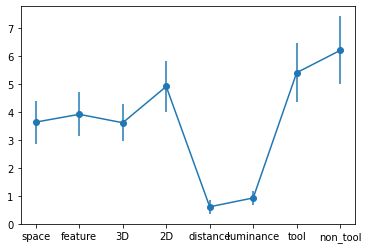

In [40]:
plot_err(summary_df, roi,cond_name, False)

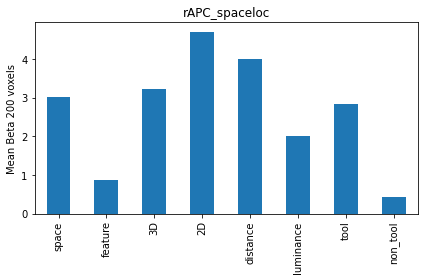

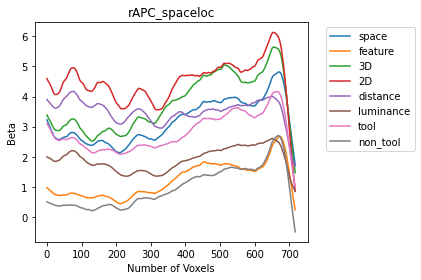

In [11]:
ss = 'spaceloc1002'
roi='rAPC_spaceloc'
#cond_list = ['space','feature']
#cond='space'
sub_dir = f'{study_dir}/sub-{ss}/ses-01/derivatives'
raw_dir = f'{sub_dir}/results/beta_ts'
results_dir = f'{sub_dir}/results/beta_summary'
n = 0
for ecn, exp_cond in enumerate(exp): #loop through each localizer task
    for cc in cond[ecn]: #loop through each condition of that localizer
        curr_df = fmri_funcs.organize_data(sub_dir,raw_dir, roi, cc, 'dist')
        if n == 0:
            df = curr_df
        else:
            df[cc] = curr_df[cc]
        n = n+1
        
cond_name = list(itertools.chain(*cond))
df_sum = df.head(peak_vox)
df_sum = df_sum.mean()

plot_bar(df_sum, roi,cond_name, False)

df_roll = df.rolling(bin_size, win_type='triang').mean()
df_roll = df_roll.dropna()
df_roll= df_roll.reset_index(drop=True)
df_roll = df_roll.head(max_vox)

plot_vsf(df_roll,roi,cond_name, 'Beta',False)

        
#df = fmri_funcs.organize_data(sub_dir,results_dir, roi, cond, 'dist')

In [30]:
print(df_sum.head())
cond_name = list(itertools.chain(*cond))
#plot_vsf(df, roi,cond_name, 'beta','nothing')
df = df[cond]
df.columns = cond
ax = df.plot.bar()
ax.set_xlabel(f"Mean Beta {peak_vox} voxels")
ax.set_ylabel(cond)

0    14.592316
1    13.901651
2    13.932179
3    14.919386
4    14.832692
dtype: float64


<AxesSubplot:>

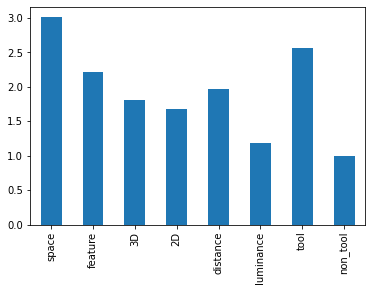

In [40]:
df_sum = df.head(500)
df_sum = df_sum.mean()
df_sum = df_sum[cond_name]
df_sum.plot.bar()